In [30]:
%matplotlib ipympl
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import IntSlider, Output
from itertools import product
from scipy.signal import find_peaks
import math
from mpl_toolkits.mplot3d import Axes3D

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, calibration, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.leap_tools import ccapt_tools

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%reload_ext autoreload

In [33]:
# Disable showing logging in Jupyter notebook
import logging, sys
logging.disable(sys.maxsize)
save_fig=False
plot_fig=True 

In [34]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [6]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam = wd.dataset_tdc_selection()
display(tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=54.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

FloatText(value=78.0, description='Detector diameter:')

$$\textbf{You can specify which dataset to use in below block}$$

In [125]:
dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]


variables.init()

variables.result_path = os.path.dirname(dataset_main_path) + '/mc_calibration/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = dataset_path

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

if tdc.value == 'leap_pos' or tdc.value == 'leap_epos':
    if tdc.value == 'leap_epos':
        data = ccapt_tools.epos_to_ccapt(filename)
    else:
        print('The file has to be epos. With pos information this tutorial cannot be run')
        data = ccapt_tools.pos_to_ccapt(filename)
else:
    data = data_tools.read_hdf5_through_pandas(filename)


In [126]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (deg),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,96.788074,7875.019531,46.0,1986.0,1986.0,0.0,1.574880,-2.295810,0,1
1,0.0,0.0,0.0,0.0,184.834798,7875.019531,46.0,2718.0,2718.0,0.0,-1.240870,-0.273416,732,1
2,0.0,0.0,0.0,0.0,98.703905,7875.019531,46.0,1998.0,1998.0,0.0,1.709700,-0.668762,4294966576,1
3,0.0,0.0,0.0,0.0,105.604788,7875.019531,46.0,2078.0,2078.0,0.0,-2.533930,2.063530,2078,1
4,0.0,0.0,0.0,0.0,105.690186,7875.019531,46.0,2070.0,2070.0,0.0,1.603760,1.711910,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490171,0.0,0.0,0.0,0.0,98.431365,6547.874512,72.0,2198.0,2198.0,0.0,-1.343130,-2.962310,2198,1
490172,0.0,0.0,0.0,0.0,98.542280,6547.874512,72.0,2199.0,2199.0,0.0,-2.036310,2.512160,2199,1
490173,0.0,0.0,0.0,0.0,96.401960,6547.874512,72.0,2178.0,2178.0,0.0,3.303280,-1.017060,2178,1
490174,0.0,0.0,0.0,0.0,98.647571,6547.874512,72.0,2187.0,2187.0,0.0,1.660160,-0.653290,0,0


d:\pyccapt\pyccapt\calibration\calibration_tools\data_loadcrop.py:174: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.subplots_adjust(right=0.75)


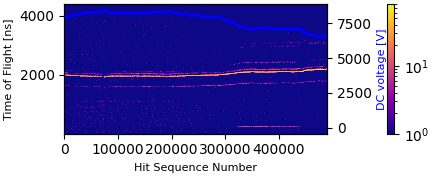

In [127]:
data_loadcrop.plot_crop_experimetn_history(data, save_name=variables.result_path + '//ex_hist_' + dataset_name)


In [128]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode.value == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode.value == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x_det (cm)'].to_numpy()
dld_y = data['y_det (cm)'].to_numpy()
mc = data['mc (Da)'].to_numpy()
# copy dld_t to a have a global version of that
variables.dld_t_calib = np.copy(dld_t)
# variables.mc_calib = np.copy(mc)
# variables.mc_calib_backup = np.copy(mc)

In [129]:
ion_distance = np.sqrt(flightPathLength_d.value**2 + (dld_x*10)**2 + (dld_y*10)**2)
ion_distance = flightPathLength_d.value / ion_distance
dld_t = dld_t * ion_distance
variables.dld_t_calib = np.copy(dld_t)

In [130]:
# peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(dld_t[dld_t < 5000], 0.5, distance=100, percent=50, prominence=100, selector='rect', plot=True, label='mc', fig_name=figname+'_orig')

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

In [131]:
def mc_hist_plot(t_0, bin_size, prominence, distance, percent, selector, plot, figname, lim_mc, flightPathLength, mode):
    mc_seb_ini = mc_tools.tof2mc(dld_t, t_0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode=mode)
    variables.mc_calib = np.copy(mc_seb_ini)
    variables.mc_calib_backup = np.copy(mc_seb_ini)
    mc = mc_seb_ini
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.mc_calib[variables.mc_calib < lim_mc], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='mc', fig_name=figname+'_ini')
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
        print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.1f}-maximum) are: ({:.2f}, {:.2f})'.format(percent, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]), '-> {:.2f}'.format(peak_widths_p_ini[i][2] - peak_widths_p_ini[i][1]))

interact_manual(mc_hist_plot, t_0=widgets.FloatText(value=t0_d.value), bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_mc=widgets.IntText(value=400)
               ,percent=widgets.IntText(value=50), selector=fixed('rect'), plot=fixed(True), figname=fixed(figname), flightPathLength=fixed(flightPathLength_d.value), mode=fixed(pulse_mode.value));


interactive(children=(FloatText(value=33.0, description='t_0'), FloatText(value=0.1, description='bin_size'), …

In [132]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=100, description='peak prominance:')
distance=widgets.IntText(value=50, description='peak distance:')
lim_tof=widgets.IntText(value=400, description='lim tof/mc:')
percent=widgets.IntText(value=50, description='percent MRP:')

def hist_plot(figname, plot):
    
    with out:
        clear_output(True)
    
        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        selector='rect'
        peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.mc_calib[variables.mc_calib < lim_tof_p], 
                                                bin_size_p, distance=distance_p, percent=percent_p, prominence=prominence_p,
                                                                    selector=selector, plot=plot, label='mc', fig_name=figname)
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
                      print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.1f}%) are: ({:.2f}, {:.2f})'.format(percent_p, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]), '-> {:.2f}'.format(peak_widths_p_ini[i][2] - peak_widths_p_ini[i][1]))

In [133]:
sample_size_b = widgets.IntText(value=11, description='sample size:') 
index_fig_b = widgets.IntText(value=1, description='fig index:')
plot_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)

save_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
def bowl_correction(dld_x, dld_y, dld_highVoltage, figname=figname):
    with out:
        sample_size_p = sample_size_b.value
        index_fig_p = index_fig_b.value
        plot_p = plot_b.value
        save_p = save_b.value

        calibration.bowl_correction_main(dld_x, dld_y, dld_highVoltage, det_diam.value, sample_size=sample_size_p, calibration_mode='mc',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p)


In [134]:
sample_size_v =widgets.IntText(value=100, description='sample size:') 
index_fig_v = widgets.IntText(value=1, description='fig index:')
plot_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)
save_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
mode_v = widgets.Dropdown(
    options=[('ion_seq', 'ion_seq'), ('voltage', 'voltage')],
    description='sample mode:'
)
peak_mode = widgets.Dropdown(
    options=[('peak', 'peak'), ('mean', 'mean'), ('median', 'median')],
    description='peak mode:'
)
def vol_correction(dld_highVoltage, figname):
    with out:
        sample_size_p = sample_size_v.value
        index_fig_p = index_fig_v.value
        plot_p = plot_v.value
        save_p = save_v.value
        mode_p = mode_v.value
        peak_mode_p = peak_mode.value
        calibration.voltage_corr_main(dld_highVoltage, sample_size=sample_size_p, calibration_mode='mc',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p, mode=mode_p, peak_mode=peak_mode_p)


In [135]:
pb_bowl = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
pb_vol = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
plot_button = widgets.Button(
    description='plot hist',
)
plot_fdm_button = widgets.Button(
    description='plot FDM',
)
reset_button = widgets.Button(
    description='reset back correction',
)
save_button = widgets.Button(
    description='save correction',
)
bowl_button = widgets.Button(
    description='bowl correction',
)
vol_button = widgets.Button(
    description='voltage correction',
)
bin_fdm = widgets.IntText(value=256, description='bin FDM:')



@plot_button.on_click
def plot_on_click(b, figname=figname, plot=True):
    hist_plot(figname, plot)

@plot_fdm_button.on_click
def plot_fdm_on_click(b, save=True):
    with out:
        clear_output(True)
        mask_temporal = np.logical_and((variables.mc_calib > variables.selected_x1),
                                       (variables.mc_calib < variables.selected_x2))
        x = dld_x[mask_temporal]
        y = dld_y[mask_temporal]
        bin_fdm_p = bin_fdm.value
        bins = [bin_fdm_p, bin_fdm_p]

        calibration.plot_FDM(x, y, save, bins)
    
@reset_button.on_click
def reset_on_click(b, figname=figname, plot=True):
    variables.mc_calib = np.copy(variables.mc_calib_backup)
    
@save_button.on_click
def save_on_click(b, figname=figname, plot=True):
    variables.mc_calib_backup = np.copy(variables.mc_calib)   
    
@bowl_button.on_click
def bowl_on_click(b, dld_x=dld_x, dld_y=dld_y, dld_highVoltage=dld_highVoltage, figname=figname):
    with out:
        clear_output(True)
        pb_bowl.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            Print('Please first select a peak')
        else:
            bowl_correction(dld_x, dld_y, dld_highVoltage, figname)  
        pb_bowl.value = "<b>Fnished</b>"
@vol_button.on_click
def vol_on_click(b, dld_highVoltage=dld_highVoltage, figname=figname):
    with out:
        clear_output(True)
        pb_vol.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            Print('Please first select a peak')
        else:
            vol_correction(dld_highVoltage, figname)
        pb_vol.value = "<b>Fnished</b>"
    


tab1 = VBox(children=[bin_size, prominence, distance, lim_tof, percent, bin_fdm])
tab2 = VBox(children=[HBox(children=[sample_size_b, index_fig_b, plot_b, save_b]), bowl_button, pb_bowl])
tab3 = VBox(children=[HBox(children=[sample_size_v, index_fig_v, mode_v, peak_mode, plot_v, save_v]), vol_button, pb_vol])

tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, 'tof/mc plot')
tab.set_title(1, 'bowl correction')
tab.set_title(2, 'voltage correction')



display(VBox(children=[tab,HBox(children=[plot_button, plot_fdm_button, save_button, reset_button])]))
out = Output()
display(out)

Output()

In [139]:
variables.mc_calib_backup = np.copy(variables.mc_calib)

In [140]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_mc):
    variables.peaks_idx = []
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.mc_calib[variables.mc_calib < lim_mc], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='mc', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
        print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [141]:

interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_mc=widgets.IntText(value=max_mc.value)
               ,percent=widgets.IntText(value=50), selector=fixed('peak'), plot=fixed(True), figname=fixed(figname+'_cor'));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [52]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), "{}({})[{}]".format(element[0], element[1], element[2]))
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

def buttonAdd_f(b,):
    with out:
        clear_output(True)
        wd.onClickAdd(b,)
        display()
def buttonDelete_f(b,):
    with out:
        clear_output(True)
        wd.onClickDelete(b,)
        display()
def buttonResett_f(b,):
    with out:
        clear_output(True)
        wd.onClickReset(b,)
        display()

listMaterial = buttonAdd.on_click(buttonAdd_f)
buttonDelete.on_click(buttonDelete_f)
buttonReset.on_click(buttonResett_f)
# listMaterial = buttonAdd.on_click(wd.onClickAdd)
# buttonDelete.on_click(wd.onClickDelete)
# buttonReset.on_click(wd.onClickReset)
out = Output()
display(out)

Dropdown(description='Elements', options=(('H (1) (99.98)', 'H(1)[1.01]'), ('H (2) (0.01)', 'H(2)[2.01]'), ('H…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

Output()

In [53]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(variables.peak[variables.peaks_idx[i]])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(variables.listMaterial)
print('highest peak in the tof histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', listMaterial)

highest peak in the tof histogram: []
highest peak in the ideal mc histogram: []


In [54]:
def shift(mc, a, b):

    # return c * ((t - t0)**2) + d
    return mc ** a + b

def shift_calib(mc, mc_ideal):
    
    fitresult, _ = curve_fit(shift, mc, mc_ideal, maxfev=2000)
    return fitresult

fitresult = shift_calib(peaks_chos,  variables.listMaterial)
mc_p_1 = shift(variables.mc_calib, *fitresult)

# f_shift = interpolate.interp1d(np.array(variables.listMaterial).T, peaks_chos.T, fill_value="extrapolate")
# variables.mc_calib = f_shift(variables.mc_calib)


ValueError: `ydata` must not be empty!

In [142]:
def mc_his(mc, bin_size, prominence, distance, percent, selector, plot, figname, lim_mc):
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc[mc < lim_mc], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='mc', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
        print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [143]:

interact_manual(mc_his, mc=fixed(variables.mc_calib), bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_mc=widgets.IntText(value=150)
               ,percent=widgets.IntText(value=50), selector=fixed('None'), plot=fixed(True), figname=fixed(figname+'_cor'));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [144]:
variables.mc_calib_backup =  variables.mc_calib

In [145]:
data['mc_c (Da)'] = variables.mc_calib_backup

In [146]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (deg),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,98.989848,96.788074,7875.019531,46.0,1986.0,1986.0,0.0,1.574880,-2.295810,0,1
1,0.0,0.0,0.0,188.759448,184.834798,7875.019531,46.0,2718.0,2718.0,0.0,-1.240870,-0.273416,732,1
2,0.0,0.0,0.0,101.231988,98.703905,7875.019531,46.0,1998.0,1998.0,0.0,1.709700,-0.668762,4294966576,1
3,0.0,0.0,0.0,108.278975,105.604788,7875.019531,46.0,2078.0,2078.0,0.0,-2.533930,2.063530,2078,1
4,0.0,0.0,0.0,108.833799,105.690186,7875.019531,46.0,2070.0,2070.0,0.0,1.603760,1.711910,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490171,0.0,0.0,0.0,99.974625,98.431365,6547.874512,72.0,2198.0,2198.0,0.0,-1.343130,-2.962310,2198,1
490172,0.0,0.0,0.0,101.049799,98.542280,6547.874512,72.0,2199.0,2199.0,0.0,-2.036310,2.512160,2199,1
490173,0.0,0.0,0.0,98.959425,96.401960,6547.874512,72.0,2178.0,2178.0,0.0,3.303280,-1.017060,2178,1
490174,0.0,0.0,0.0,101.020582,98.647571,6547.874512,72.0,2187.0,2187.0,0.0,1.660160,-0.653290,0,0


In [147]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data, 'df')

In [148]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data, pulse_mode=pulse_mode.value, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data, path=variables.result_path, name=dataset_name + '.pos')

In [149]:
# save data in csv format
data_tools.store_df_to_csv(data, variables.result_path + dataset_name + '.csv')